In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

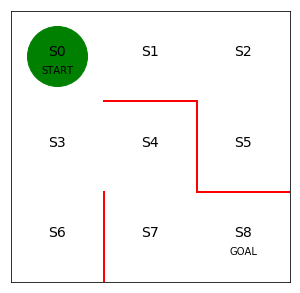

In [2]:
# init maze

fig = plt.figure(figsize=(5, 5))
ax = plt.gca() # current axes

# red wall
plt.plot([1, 1], [0, 1], color='red',linewidth=2)
plt.plot([1, 2], [2, 2], color='red',linewidth=2)
plt.plot([2, 2], [2, 1], color='red',linewidth=2)
plt.plot([2, 3], [1, 1], color='red',linewidth=2)

# states
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)

In [3]:
# init param(thetha_0) of the policy

# row (up, right, down, left)
theta_0 = np.array([[np.nan, 1, 1, np.nan], # S0
                     [np.nan, 1, np.nan, 1], # S1
                     [np.nan, np.nan, 1, 1], # S2
                     [1, 1, 1, np.nan], # S3
                     [np.nan, np.nan, 1, 1], # S4
                     [1, np.nan, np.nan, np.nan], # S5
                     [1, np.nan, np.nan, np.nan], # S6
                     [1, 1, np.nan, np.nan] # S7, S8 is goal
                    ])

In [4]:
# Q : 행동가치 함수

[a, b] = theta_0.shape # (8, 4)
Q = np.random.rand(a, b) * theta_0 * 0.1
# * theta_0으로 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan을 부여
print(Q)

[[       nan 0.09234143 0.09868885        nan]
 [       nan 0.03805873        nan 0.02369229]
 [       nan        nan 0.03276177 0.07227075]
 [0.04024998 0.08477518 0.09860116        nan]
 [       nan        nan 0.04026059 0.0476386 ]
 [0.00331021        nan        nan        nan]
 [0.01703265        nan        nan        nan]
 [0.03651689 0.05511851        nan        nan]]


In [5]:
# convert into action policy from theta(policy param)
def simple_convert_into_pi_from_theta(theta):
    [m,n] = theta.shape
    pi = np.zeros((m,n)) # same size of theta
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # average of policy
        
    pi = np.nan_to_num(pi) # Replace NaN with zero and infinity with large finite numbers.
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [6]:
# epsilon-greedy algorithm

def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    
    # explore
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    # exploit
    else:
        next_direction = direction[np.nanargmax(Q[s, :])] # nanargmax : index of nan
        
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3
        
    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]
    
    if next_direction == "up":
        s_next = s - 3
    elif next_direction == "right":
        s_next = s + 1
    elif next_direction == "down":
        s_next = s + 3
    elif next_direction == "left":
        s_next = s - 1
        
    return s_next

In [7]:
# Q-learning algorithm

def Q_learning(s, a, r, s_next, Q, eta, gamma):
    if s_next == 8:
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])
    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,:]) - Q[s, a])
        
    return Q

In [8]:
# a : action, s : state, r : reward, eta : learning rate
def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0
    a = a_next = get_action(s, Q, epsilon, pi)
    s_a_history = [[0, np.nan]] # [state, action]
    
    while (1):
        a = a_next # get the next action
        s_a_history[-1][1] = a # save the current action
        s_next = get_s_next(s, a, Q, epsilon, pi) # get th next state
        s_a_history.append([s_next, np.nan]) # save the current state
        
        if s_next == 8: # goal
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi) # next action
            
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma) # update the policy by Q-learning
        
        if s_next == 8:
            break
        else:
            s = s_next
            
    return [s_a_history, Q]

In [9]:
eta = 0.1 # learning rate
gamma = 0.9 # 시간할인율
epsilon = 0.5
v = np.nanmax(Q, axis=1) # maximun value of each states(row)
is_continue = True
episode = 1

V = [] # state value of each episodes, [S0, S1, S2, S3, S4, S5, S6, S7]
V.append(np.nanmax(Q, axis=1))

step = []

while is_continue:
    print("============================")
    print("episode : " + str(episode))
    
    epsilon = epsilon / 2
    
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)
    
    new_v = np.nanmax(Q, axis=1)
    print(np.sum(np.abs(new_v - v))) # change of stats values
    v = new_v
    V.append(v)
    print("step : " + str(len(s_a_history) - 1))
    
    step.append(len(s_a_history) - 1)
    
    episode += 1
    if episode > 100:
        break

episode : 1
0.2789834899515168
step : 274
episode : 2
0.09210344643954094
step : 28
episode : 3
0.09397650737727975
step : 8
episode : 4
0.09342344619294729
step : 12
episode : 5
0.09122470554125292
step : 6
episode : 6
0.08927099417127698
step : 4
episode : 7
0.08837282699323254
step : 4
episode : 8
0.08744395433426103
step : 4
episode : 9
0.08647193590966501
step : 4
episode : 10
0.08544581544677689
step : 4
episode : 11
0.08435648613587018
step : 4
episode : 12
0.08319687369167142
step : 4
episode : 13
0.08196198336215826
step : 4
episode : 14
0.0806488480198138
step : 4
episode : 15
0.07925640686240976
step : 4
episode : 16
0.07778533798332815
step : 4
episode : 17
0.07623786293053494
step : 4
episode : 18
0.07461753717593775
step : 4
episode : 19
0.07292903700793434
step : 4
episode : 20
0.0711779506080839
step : 4
episode : 21
0.06937057886685222
step : 4
episode : 22
0.06751374973938362
step : 4
episode : 23
0.06561464856114624
step : 4
episode : 24
0.06368066566849953
step : 4


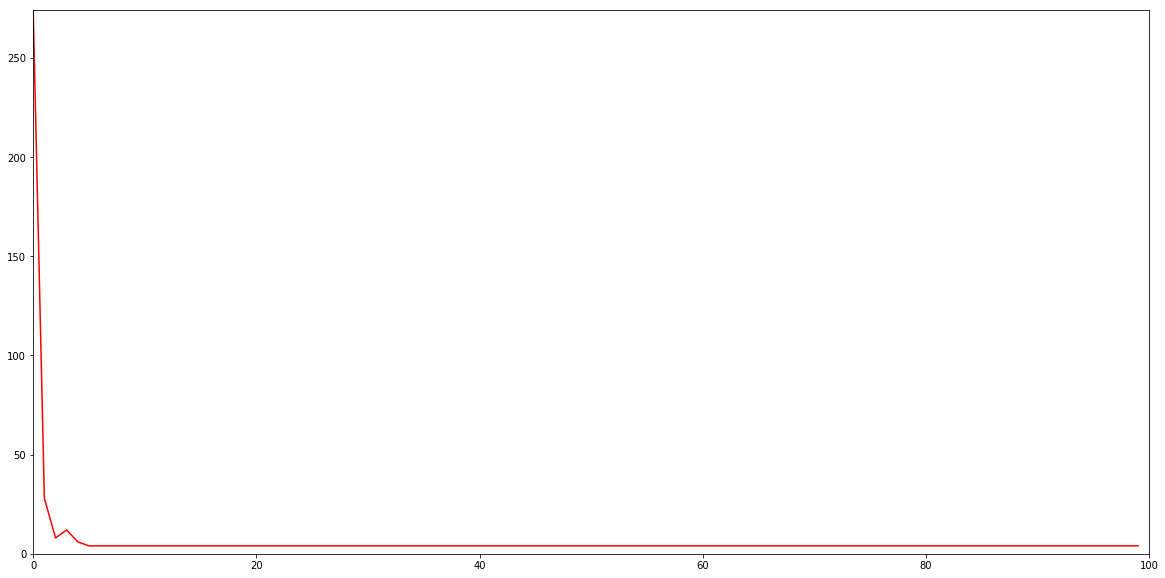

In [10]:
from matplotlib.pyplot import figure
figure(figsize=(20,10))
plt.plot(step, 'r')
plt.axis([0, 100, 0, max(step)])
plt.show()

In [11]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    line, = ax.plot([0.5], [2.5], marker="s", color=cm.jet(V[i][0]), markersize=85) # S0
    line, = ax.plot([1.5], [2.5], marker="s", color=cm.jet(V[i][1]), markersize=85) # S1
    line, = ax.plot([2.5], [2.5], marker="s", color=cm.jet(V[i][2]), markersize=85) # S2
    line, = ax.plot([0.5], [1.5], marker="s", color=cm.jet(V[i][3]), markersize=85) # S3
    line, = ax.plot([1.5], [1.5], marker="s", color=cm.jet(V[i][4]), markersize=85) # S4
    line, = ax.plot([2.5], [1.5], marker="s", color=cm.jet(V[i][5]), markersize=85) # S5
    line, = ax.plot([0.5], [0.5], marker="s", color=cm.jet(V[i][6]), markersize=85) # S6
    line, = ax.plot([1.5], [0.5], marker="s", color=cm.jet(V[i][7]), markersize=85) # S7
    line, = ax.plot([2.5], [0.5], marker="s", color=cm.jet(1.0), markersize=85) # S8
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)
HTML(anim.to_jshtml())